## 9-2. 워드투벡터(Word2Vec)


앞서 원-핫 벡터는 단어 벡터 간 유의미한 유사도를 계산할 수 없다는 단점이 있음을 언급한 적이 있습니다. 그래서 단어 벡터 간 유의미한 유사도를 반영할 수 있도록 단어의 의미를 수치화 할 수 있는 방법이 필요합니다. 



CBOW(Continuous Bag of Words)
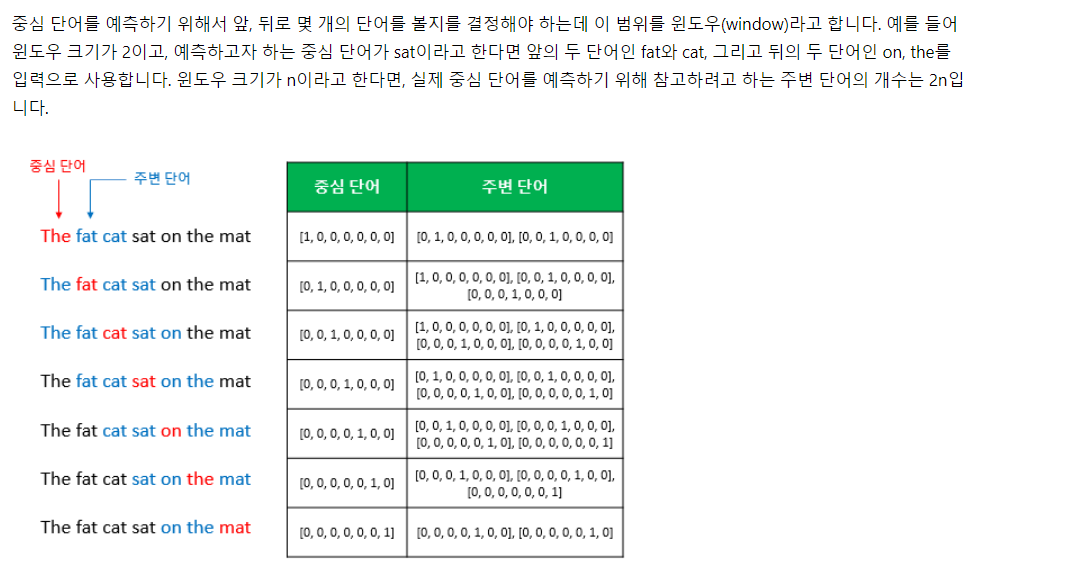

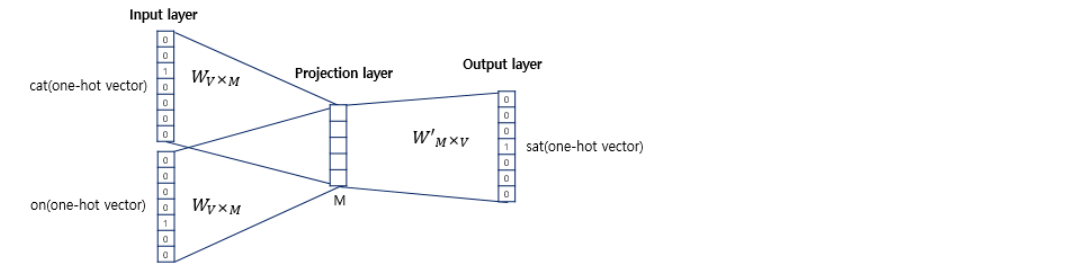

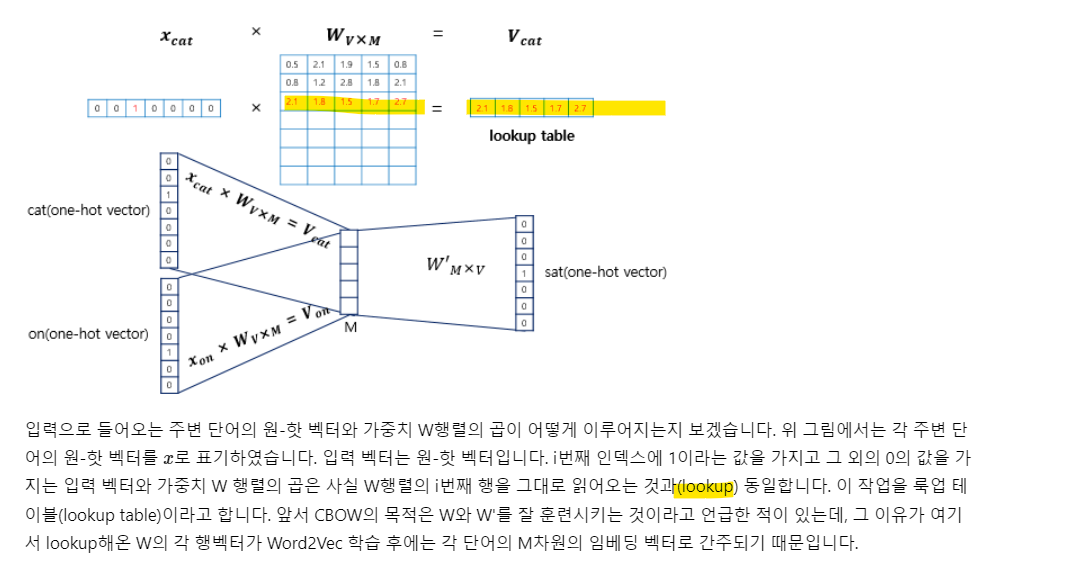
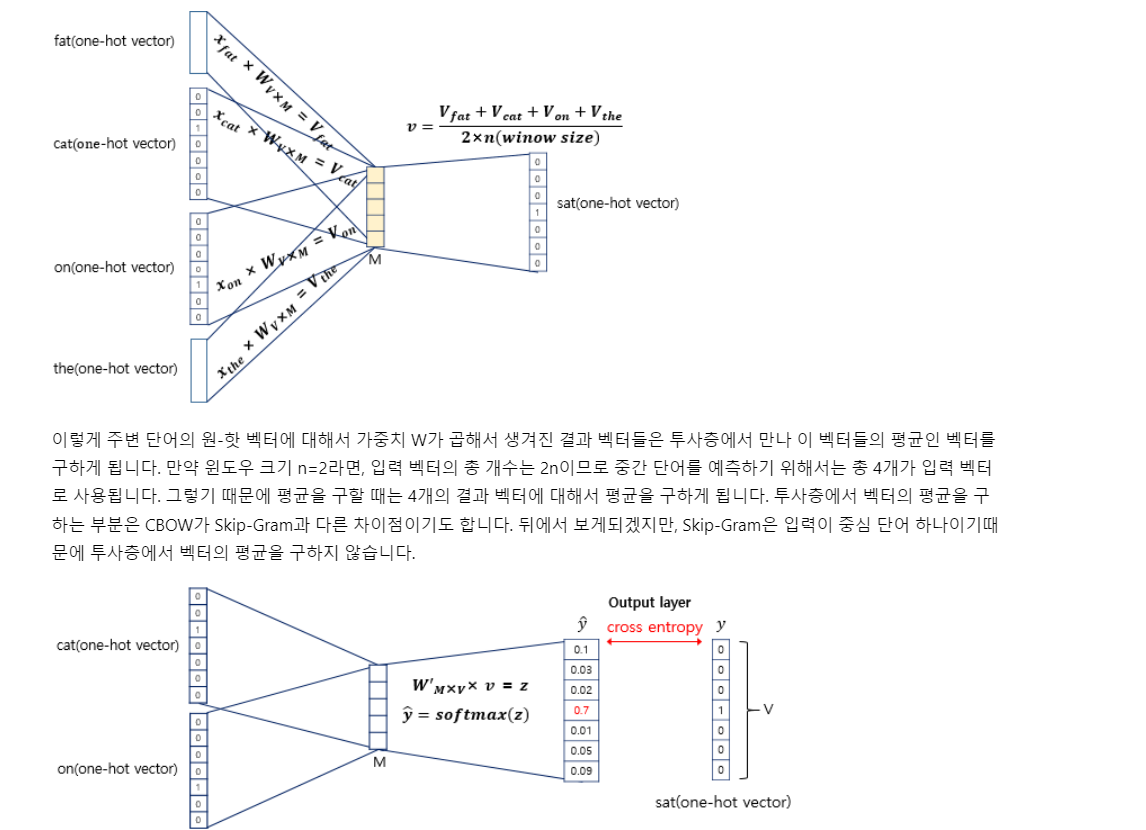

4. Skip-gram


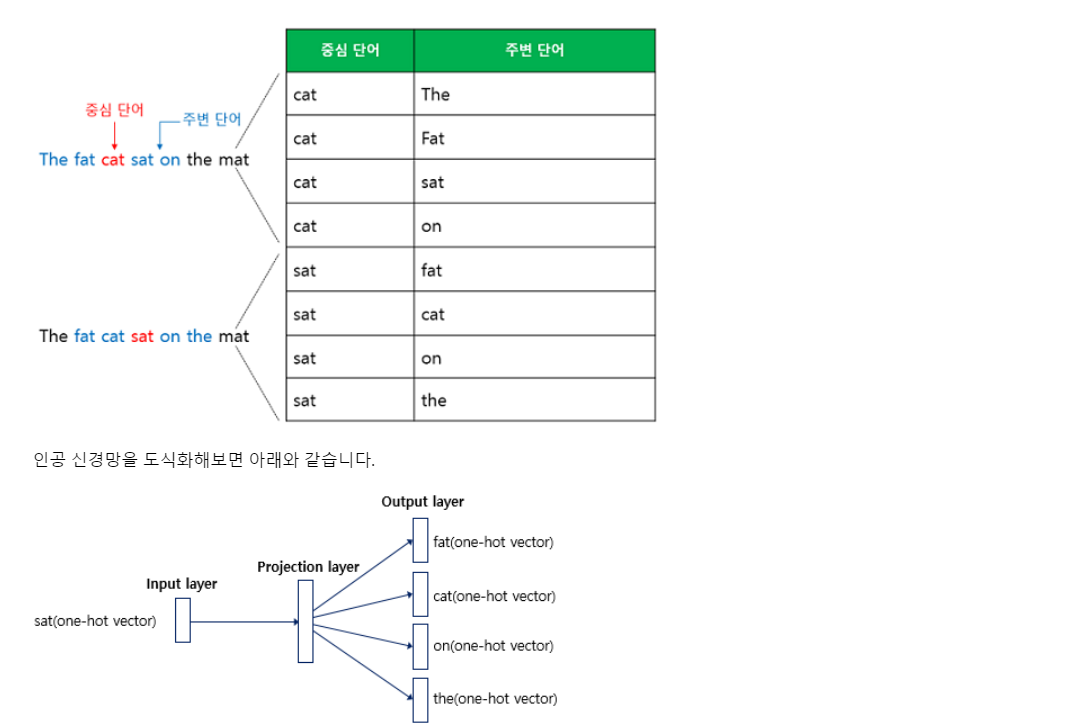

### 03) 영어/한국어 Word2Vec 실습

In [1]:
import re
import urllib.request
import zipfile
from lxml import etree
from nltk.tokenize import word_tokenize, sent_tokenize

In [2]:
# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/09.%20Word%20Embedding/dataset/ted_en-20160408.xml", filename="ted_en-20160408.xml")

('ted_en-20160408.xml', <http.client.HTTPMessage at 0x1cf5f2afd90>)

<file id="1">
  <head>
<url>http://www.ted.com/talks/knut_haanaes_two_reasons_companies_fail_and_how_to_avoid_them</url>
       <pagesize>72832</pagesize>
... xml 문법 중략 ...
<content>
Here are two reasons companies fail: they only do more of the same, or they only do what's new.
To me the real, real solution to quality growth is figuring out the balance between two activities:
... content 내용 중략 ...
To me, the irony about the Facit story is hearing about the Facit engineers, who had bought cheap, small electronic calculators in Japan that they used to double-check their calculators.
(Laughter)
... content 내용 중략 ...
(Applause)
</content>
</file>
<file id="2">
    <head>
<url>http://www.ted.com/talks/lisa_nip_how_humans_could_evolve_to_survive_in_space<url>
... 이하 중략 ...

In [3]:
targetXML = open('ted_en-20160408.xml', 'r', encoding='UTF8')
target_text = etree.parse(targetXML)

# xml 파일로부터 <content>와 </content> 사이의 내용만 가져온다.
parse_text = '\n'.join(target_text.xpath('//content/text()'))

# 정규 표현식의 sub 모듈을 통해 content 중간에 등장하는 (Audio), (Laughter) 등의 배경음 부분을 제거.
# 해당 코드는 괄호로 구성된 내용을 제거.
content_text = re.sub(r'\([^)]*\)', '', parse_text)

# 입력 코퍼스에 대해서 NLTK를 이용하여 문장 토큰화를 수행.
sent_text = sent_tokenize(content_text)

# 각 문장에 대해서 구두점을 제거하고, 대문자를 소문자로 변환.
normalized_text = []
for string in sent_text:
     tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
     normalized_text.append(tokens)

# 각 문장에 대해서 NLTK를 이용하여 단어 토큰화를 수행.
result = [word_tokenize(sentence) for sentence in normalized_text]

In [4]:
print('총 샘플의 개수 : {}'.format(len(result)))

총 샘플의 개수 : 273424


In [5]:
# 샘플 3개만 출력
for line in result[:3]:
    print(line)

['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new']
['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation']
['both', 'are', 'necessary', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing']


In [8]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

model = Word2Vec(sentences=result, vector_size=100, window=5, min_count=5, workers=4, sg=0)

size = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원.
window = 컨텍스트 윈도우 크기
min_count = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.)
workers = 학습을 위한 프로세스 수
sg = 0은 CBOW, 1은 Skip-gram.

In [9]:
model_result = model.wv.most_similar("man")
print(model_result)

[('woman', 0.8301951289176941), ('guy', 0.8057891726493835), ('boy', 0.7787166237831116), ('lady', 0.774594783782959), ('girl', 0.7506555914878845), ('soldier', 0.7342104315757751), ('kid', 0.7187970280647278), ('gentleman', 0.7187405228614807), ('poet', 0.6820864677429199), ('photographer', 0.6619123220443726)]


In [10]:
model.wv.save_word2vec_format('eng_w2v') # 모델 저장
loaded_model = KeyedVectors.load_word2vec_format("eng_w2v") # 모델 로드

In [11]:
model_result = loaded_model.most_similar("man")
print(model_result)

[('woman', 0.8301951289176941), ('guy', 0.8057891726493835), ('boy', 0.7787166237831116), ('lady', 0.774594783782959), ('girl', 0.7506555914878845), ('soldier', 0.7342104315757751), ('kid', 0.7187970280647278), ('gentleman', 0.7187405228614807), ('poet', 0.6820864677429199), ('photographer', 0.6619123220443726)]


### 2. 한국어 Word2Vec 만들기(네이버 영화 리뷰)


In [13]:
!pip install konlpy

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

In [15]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x1cf687f6880>)

In [16]:
train_data = pd.read_table('ratings.txt')

In [17]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [18]:
print(len(train_data)) # 리뷰 개수 출력

200000


In [19]:
# NULL 값 존재 유무
print(train_data.isnull().values.any())

True


In [20]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [21]:
print(len(train_data)) # 리뷰 개수 출력

199992


In [22]:
# 정규 표현식을 통한 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

C:\Users\HOME\AppData\Local\Temp/ipykernel_15684/2087193524.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [23]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1


In [24]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()

tokenized_data = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)

JVMNotFoundException: No JVM shared library file (jvm.dll) found. Try setting up the JAVA_HOME environment variable properly.

In [ ]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(review) for review in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
from gensim.models import Word2Vec

model = Word2Vec(sentences = tokenized_data, vector_size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

In [ ]:
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

In [ ]:
print(model.wv.most_similar("최민식"))

### 3. 사전 훈련된 Word2Vec 임베딩(Pre-trained Word2Vec embedding) 소개

자연어 처리 작업을 할때, 케라스의 Embedding()를 사용하여 갖고 있는 훈련 데이터로부터 처음부터 임베딩 벡터를 훈련시키기도 하지만, 위키피디아 등의 방대한 데이터로 사전에 훈련된 워드 임베딩(pre-trained word embedding vector)를 가지고 와서 해당 벡터들의 값을 원하는 작업에 사용 할 수도 있습니다.

예를 들어서 감성 분류 작업을 하는데 훈련 데이터의 양이 부족한 상황이라면, 다른 방대한 데이터를 Word2Vec이나 GloVe 등으로 사전에 학습시켜놓은 임베딩 벡터들을 가지고 와서 모델의 입력으로 사용하는 것이 때로는 더 좋은 성능을 얻을 수 있습니다. 사전 훈련된 워드 임베딩을 가져와서 간단히 단어들의 유사도를 구해보는 실습을 해보겠습니다. 실제로 모델에 적용해보는 실습은 향후에 진행합니다.




In [25]:
import gensim
import urllib.request

# 구글의 사전 훈련된 Word2Vec 모델을 로드.
urllib.request.urlretrieve("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz", \
                           filename="GoogleNews-vectors-negative300.bin.gz")
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

HTTPError: HTTP Error 404: Not Found

In [ ]:
print(word2vec_model.vectors.shape)

In [ ]:
print(word2vec_model.similarity('this', 'is'))
print(word2vec_model.similarity('post', 'book'))

In [ ]:
print(word2vec_model['book'])